# **L&T EduTech Hackathon at SHAASTRA IITM**

### **Problem Statement 1:**
Description: Concrete cracking is a major issue in Bridge Engineering. Detection of cracks facilitates the design, construction and maintenance of bridges effectively.

###**Requirement Specification:**
Develop a suitable Deep Learning framework which can detect the crack in the image from the dataset

### **Judging Metrics:** 
Provide Precision, Recall and F1 score as Judging metrics

###**Dataset Description:**
There are 600 iamges which contains 300 images of cracked surface and 300 of non-cracked images. In the test and validation dataset there are 200 images in each dataset.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
!pip install opendatasets
import opendatasets as od

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
od.download('https://www.kaggle.com/datasets/xinzone/surface-crack')

Skipping, found downloaded files in "./surface-crack" (use force=True to force download)


In [37]:
# Set the image path
img_path = r'/content/surface-crack/test/Positive/DJI_0677_10_16.jpg'
# Read the image
image = cv2.imread(img_path)
print(image.shape)

(224, 224, 3)


In [38]:
IMG_SHAPE = (224,224,3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')

In [39]:
batch_size=20         #Setting batch size
train_dir = "/content/surface-crack/train"   #Setting training directory
validation_dir = "/content/surface-crack/valid" #Setting validation directory
test_dir = "/content/surface-crack/test" #Setting testing directory


# All images will be rescaled between 0 to 1.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
val_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )
# Flow training images in batches of 20 using train_datagen generator
#Flow_from_directory function lets the classifier directly identify the labels from the name of the directories the image lies in
train_generator=train_datagen.flow_from_directory(train_dir,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  target_size=(224,224))

validation_generator =  val_datagen.flow_from_directory(validation_dir,
                                                         batch_size=batch_size,
                                                         class_mode  = 'categorical',
                                                         target_size=(224,224))

test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=batch_size,
                                                         class_mode  = 'categorical',
                                                         target_size=(224,224),
                                                         shuffle = False
                                                   )

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [40]:
test_generator.class_indices

{'Negative': 0, 'Positive': 1}

## Fine tuning

In [41]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


In [42]:
model1 = tf.keras.Sequential([
  base_model,
  Flatten(),
  Dense(128, activation = 'relu'),
  tf.keras.layers.Dense(2, activation='softmax')
])

In [43]:
model1.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

In [44]:
history_fine = model1.fit(train_generator, 
                          steps_per_epoch = train_generator.n // batch_size,
                          epochs=30,
                          validation_data=validation_generator, 
                          validation_steps=validation_generator.n // batch_size,
                          callbacks = EarlyStopping(patience=4),
                          verbose = 2)

Epoch 1/30
30/30 - 6s - loss: 0.6132 - accuracy: 0.7417 - val_loss: 0.5230 - val_accuracy: 0.8000 - 6s/epoch - 217ms/step
Epoch 2/30
30/30 - 3s - loss: 0.1760 - accuracy: 0.9650 - val_loss: 0.3741 - val_accuracy: 0.8950 - 3s/epoch - 102ms/step
Epoch 3/30
30/30 - 4s - loss: 0.0886 - accuracy: 0.9833 - val_loss: 0.3211 - val_accuracy: 0.9100 - 4s/epoch - 146ms/step
Epoch 4/30
30/30 - 3s - loss: 0.0476 - accuracy: 0.9917 - val_loss: 0.3417 - val_accuracy: 0.8550 - 3s/epoch - 111ms/step
Epoch 5/30
30/30 - 2s - loss: 0.0287 - accuracy: 0.9983 - val_loss: 0.3055 - val_accuracy: 0.8900 - 2s/epoch - 65ms/step
Epoch 6/30
30/30 - 2s - loss: 0.0269 - accuracy: 0.9967 - val_loss: 0.2937 - val_accuracy: 0.8900 - 2s/epoch - 63ms/step
Epoch 7/30
30/30 - 2s - loss: 0.0316 - accuracy: 0.9967 - val_loss: 0.3207 - val_accuracy: 0.8750 - 2s/epoch - 64ms/step
Epoch 8/30
30/30 - 2s - loss: 0.0201 - accuracy: 0.9983 - val_loss: 0.2351 - val_accuracy: 0.9150 - 2s/epoch - 64ms/step
Epoch 9/30
30/30 - 2s - loss

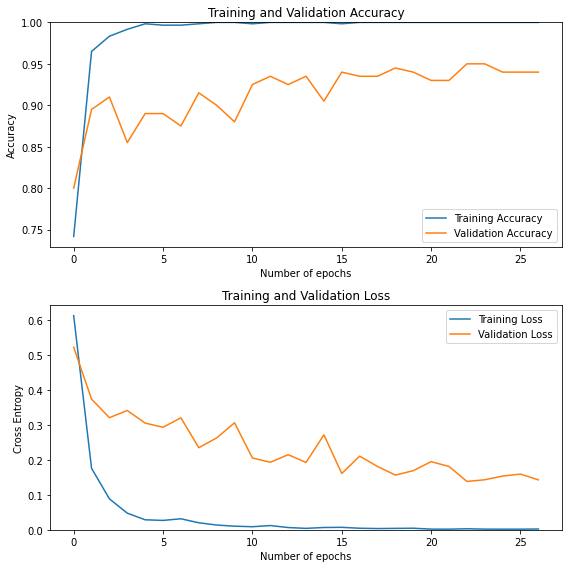

In [45]:
# plotting the accuracy and loss results over epochs 
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Number of epochs')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.show()

In [46]:
#predict
y_pred2=model1.predict(test_generator)
y_pred2=np.argmax(y_pred2,axis=1)

10/10 [==============================] - 1s 41ms/step


In [47]:
consfusion_mat2 = confusion_matrix(test_generator.classes, y_pred2)
print(consfusion_mat2)

[[100   0]
 [  3  97]]


In [48]:
print("\nReport :\n ",
    classification_report(test_generator.classes, y_pred2))


Report :
                precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.98       100

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200

